In [1]:
#import libs
import pandas as pd
import numpy as np
import random

import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
from datetime import datetime

import os, warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

import math
from sklearn.metrics import mean_squared_error

In [3]:
# read synoptic data Of Shz
sfile = r'./data/Shiraz.xlsx'

xl = pd.ExcelFile(sfile)
df = xl.parse('Sheet1')

# average temperature 
df['date'] = df['year'].map(str)+'-'+df['month'].map(str)
avg_t = df[['date', 'avgTemp']][:]
avg_t['date'] = pd.to_datetime(avg_t.date, format='%Y-%m')
avg_t.set_index('date', inplace=True)

avg_t.tail(2)

,avgTemp
date,
2017-11-01,12.2
2017-12-01,8.8


computation started
computation completed
 forecast for  12  steps ahead with seasonal additive
RMSE:  1.2740740724436004


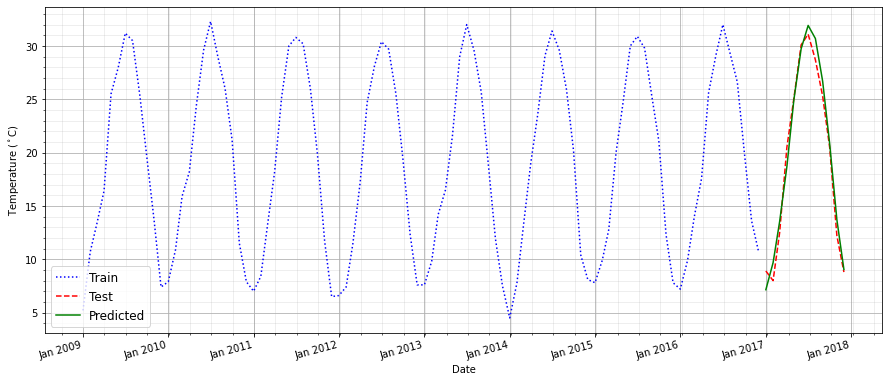

In [4]:
## Forecasting 12 months ahead
start_index = 384 
offset = 12
train = avg_t[-(start_index+offset):-offset]
test = avg_t[-offset:]

y_hat_avg = test.copy()
print ('computation started')
fit1 = ExponentialSmoothing(np.asarray(train['avgTemp']), seasonal_periods=12, trend='add', seasonal='add').fit()
y_hat_avg['predict'] = fit1.forecast(len(test))
print ('computation completed')

print(' forecast for ', offset, ' steps ahead with seasonal additive')
print('RMSE: ', math.sqrt(mean_squared_error(y_hat_avg['predict'], test['avgTemp'].values)))

# plot forecast
fig, ax = plt.subplots(figsize=(15, 6))
ax.set(xlabel="Date", ylabel="Temperature ($^\circ$C)",)

ax.plot(train['avgTemp'][-96:], 'b:', label='Train', color='blue')
ax.plot(test['avgTemp'], 'r--', label='Test', color='red')
ax.plot(y_hat_avg['predict'], 'k-', label='Predicted', color='green')

# Define the date format
date_form = mdates.DateFormatter("%b %Y")
ax.xaxis.set_major_formatter(date_form)
plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
plt.legend(loc='best', fontsize=12)
plt.grid(True)
# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.savefig(r'./images/predict_12m.jpg', dpi=500)
plt.show()

In [5]:
# Forecasting and benchmarking
def benchmarking(df, var_name, result_file, no_exper = 10):
    end_index_of_df = len(df)
    
    lead_times = [1, 3, 6, 9, 12]
    previous_time = 240
    
    no_of_experiments = no_exper

    text_file = open(result_file, "w")
    text_file.write("time, our, naive, average \n")

    for item in lead_times:
        lead_time = item
        #print('computing for lead time = ', str(lead_time), ' hours with history of ', str(previous_time), ' hours')
       
        rmse_array = []
        persist_array = []
        average_array = []
        
        for _ in range(no_of_experiments):
            offset = previous_time + lead_time
            start_index = random.randint(0, end_index_of_df - offset)
           
            train = df[start_index:start_index+previous_time]
            test = df[start_index+previous_time:start_index+offset]

            y_hat_avg = test.copy()
            #print('computation started')
                        
            fit1 = ExponentialSmoothing(np.asarray(train[var_name]), seasonal_periods=12, trend='add', seasonal='add').fit()
            y_hat_avg['predicted'] = fit1.forecast(len(test))
            
            # persistence
            last_value = train[var_name].iloc[-1]
            y_hat_avg['naive'] = last_value * np.ones(len(test))

            # average
            mean_training_value = np.mean(train[var_name])
            y_hat_avg['aver'] = mean_training_value * np.ones(len(test))

            #print('computation completed')

            # computing the error for exponential smoothing
            a = y_hat_avg[var_name]
            b = y_hat_avg['predicted']
            rmse_value = np.sqrt(np.mean((b - a) ** 2))
            rmse_array.append(rmse_value)
                    
            # computing the error for persistence model
            a = y_hat_avg[var_name]
            b = y_hat_avg['naive']
            rmse_value = np.sqrt(np.mean((b - a) ** 2))
            persist_array.append(rmse_value)

            # computing the error for average model
            a = y_hat_avg[var_name]
            b = y_hat_avg['aver']
            rmse_value = np.sqrt(np.mean((b - a) ** 2))
            average_array.append(rmse_value)

        rmse_array = np.array(rmse_array)
        #print('lead time: ', lead_time, 'best rmse: ', min(rmse_array))
        persist_array = np.array(persist_array)
        average_array = np.array(average_array)

        text_file.write("%s, %s, %s, %s \n" % (lead_time, np.mean(rmse_array), np.mean(persist_array), np.mean(average_array)))
         
    text_file.close()
    

In [8]:
no_exprs = 100
res_file = r'./results/comparisons_'+str(no_exprs)+'run.txt'
benchmarking(avg_t, 'avgTemp', res_file, no_exprs)